In [74]:
import xml.etree.cElementTree as ET
import nltk
from functools import reduce
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

1)

In [117]:
def tokenize(text, remove_stopwords=False):
    stopWords = set(stopwords.words('english'))|set(["''",",''",".''",".,'","...",".,",'``'])
    tokens = nltk.wordpunct_tokenize(text)
    tokens = [word.lower() for word in tokens if len(word) > 1]
    tokens = [word for word in tokens if not (word in stopWords and remove_stopwords) and not word.isdigit()]
    
    porter_stemmer = PorterStemmer()
    #tokens = [porter_stemmer.stem(word) for word in tokens]
    return tokens

In [76]:
root = ET.ElementTree(file='ap/ap.xml').getroot()

dic = {}
full_text = []
for node in root:
    docno, text = node
    dic[docno.text.strip()] = text.text

full_text = ''.join([v for k,v in dic.items()])

In [91]:
tokens = tokenize(full_text)
fd = nltk.FreqDist(tokens)
most_common_s = set(sorted(fd, key=lambda x: fd[x],reverse=True)[:500])
most_common_s

{'accord',
 'account',
 'accus',
 'across',
 'act',
 'action',
 'activ',
 'ad',
 'addit',
 'administr',
 'agenc',
 'ago',
 'agre',
 'agreement',
 'aid',
 'air',
 'airlin',
 'alleg',
 'allow',
 'alreadi',
 'also',
 'america',
 'american',
 'among',
 'analyst',
 'announc',
 'anoth',
 'anti',
 'appeal',
 'appear',
 'approv',
 'april',
 'area',
 'arm',
 'armi',
 'around',
 'arrest',
 'ask',
 'assist',
 'associ',
 'attack',
 'attorney',
 'author',
 'averag',
 'away',
 'back',
 'bank',
 'base',
 'becom',
 'began',
 'begin',
 'believ',
 'big',
 'bill',
 'billion',
 'black',
 'board',
 'bond',
 'budget',
 'build',
 'bush',
 'busi',
 'buy',
 'california',
 'call',
 'came',
 'campaign',
 'candid',
 'capit',
 'car',
 'care',
 'carri',
 'case',
 'caus',
 'cent',
 'center',
 'central',
 'chairman',
 'chang',
 'charg',
 'chief',
 'children',
 'citi',
 'claim',
 'close',
 'co',
 'come',
 'comment',
 'committe',
 'commun',
 'communist',
 'compani',
 'concern',
 'condit',
 'confer',
 'congress',
 'cons

In [90]:
window_size = 2
bgm    = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(tokens, window_size)
finder.apply_ngram_filter(lambda w1, w2: w1 not in most_common_s or w2 not in most_common_s)
scored = finder.score_ngrams( bgm.likelihood_ratio  )
scored

[(('new', 'york'), 7482.598390739796),
 (('unit', 'state'), 7010.588850427001),
 (('year', 'old'), 3608.2910237682017),
 (('vice', 'presid'), 2667.9729689619585),
 (('soviet', 'union'), 2601.7802418879915),
 (('last', 'year'), 2461.5872360148323),
 (('year', 'ago'), 2267.9559006306495),
 (('white', 'hous'), 2107.4670095472316),
 (('prime', 'minist'), 2055.017837100759),
 (('last', 'week'), 1956.8046519376514),
 (('news', 'confer'), 1680.7533933165819),
 (('stock', 'exchang'), 1543.9159959585388),
 (('west', 'german'), 1485.3915922708184),
 (('human', 'right'), 1360.1112010828163),
 (('interest', 'rate'), 1313.9360513563315),
 (('news', 'agenc'), 1294.1415985258855),
 (('offici', 'said'), 1237.2281320233724),
 (('west', 'germani'), 1151.9140048793547),
 (('communist', 'parti'), 1147.1928967577865),
 (('air', 'forc'), 1131.4272806406789),
 (('attorney', 'gener'), 1120.9973595251893),
 (('last', 'month'), 1115.8449169663363),
 (('told', 'report'), 982.7682372143659),
 (('georg', 'bush'), 

2)

In [118]:
orig_species_f = open('ap/pg1228.txt', 'r')
inputfile = orig_species_f.read()
tokens_orig = tokenize(inputfile, False)

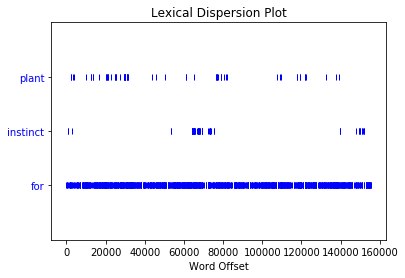

In [120]:
nltk.draw.dispersion.dispersion_plot(tokens_orig,['plant','instinct','for'])

In [122]:
instinct_app = [for word in enumerate(tokens_orig]
plant_app = []

None
